In [54]:
import cvxpy as cvx
import numpy as np

import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error as mae


import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal

# # CVXPY
# from solardatatools.signal_decompositions import tl1_l1d1_l2d2p365 as cvx_sd
# # OSD
# from solardatatools.osd_signal_decompositions import tl1_l1d1_l2d2p365 as osd_sd
import cvxpy as cvx
from gfosd import Problem
from gfosd.components import SumAbs, SumSquare, SumCard, SumQuantile, Aggregate, AverageEqual, Periodic, Inequality


np.random.seed(12) 
random.seed(10)

## `make_l2_l1d2`

### Create input signal

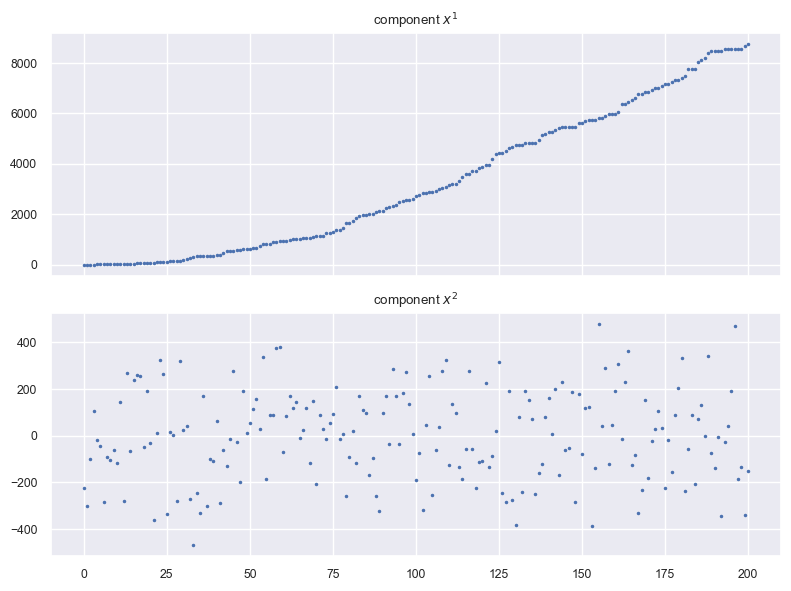

In [2]:
t = 200

# piecewise linear term
x_points = np.random.randint(low=0, high=200, size=t)
x_points.sort()
x_points = np.append(0, x_points)  # the first 0 point is 0
slopes = np.add.accumulate(np.random.random(size=t-1))
slopes = np.append(0,slopes)  # the first slope is 0
y_incr = np.ediff1d(x_points)*slopes
y_points = np.add.accumulate(y_incr)
y_points = np.append(0,y_points)  # the first y values is 0

# gaussian noise
signal2 = 200 * np.random.randn(len(y_points))

X_real = np.zeros((2, len(y_points)), dtype=float)
X_real[0] = y_points
X_real[1] = signal2
#X_real[2] = signal2 + y_points
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

In [49]:
def cvx_sd(y, weight=300, comp_osd=None):
    y_hat = cvx.Variable(len(y))
    y_param = cvx.Parameter(len(y), value=y)
    mu = cvx.Parameter(nonneg=True)
    mu.value = weight
    error = cvx.sum_squares(y_param - y_hat)
    reg = cvx.norm(cvx.diff(y_hat, k=2), p=1)
    objective = cvx.Minimize(error + mu * reg)
    constraints = [y_param[0] == y_hat[0], y[-1] == y_hat[-1]]
    problem = cvx.Problem(objective, constraints)

    problem.solve(solver="MOSEK")
    
    if comp_osd is not None:
        print(f"CVXPY objective       {problem.objective.value:.5f}")
        y_hat.value = comp_osd
        print(f"OSD objective, scaled {problem.objective.value:.5f}")
        return problem.objective.value
    
    return y_hat.value

In [102]:
def osd_sd(y, weight=300, solver="MOSEK"):
    c1 = SumSquare(weight=1)    
    c2 = Aggregate([
        SumAbs(weight=weight, diff=2), 
        Inequality(vmin=y[0], vmax=y[-1], diff=1)
                 ])
    classes = [c1, c2]
    
    problem = Problem(y, classes)
    problem.decompose(solver=solver)
    
    y_hat = problem.decomposition[1]
    
    return y_hat

# MOSEK/MOSEK

CVXPY objective       7860814.04303
OSD objective, scaled 7860817.14013
s_hat MAE (OSD,CVX)   4.83e-03


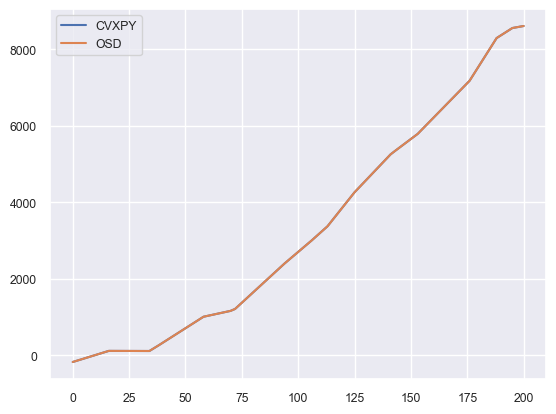

In [104]:
s_hat_cvxpy_mosek = cvx_sd(y, weight=3000)
s_hat_osd_mosek = osd_sd(y, weight=3000)

obj_osd_scaled = cvx_sd(y, weight=3000, comp_osd=s_hat_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(s_hat_cvxpy_mosek, s_hat_osd_mosek):.2e}')


f, ax1 = plt.subplots()
ax1.plot(s_hat_cvxpy_mosek, label="CVXPY")
ax1.plot(s_hat_osd_mosek, label="OSD")
ax1.legend()
plt.show()

# MOSEK/QSS

CVXPY objective       7860814.04303
OSD objective, scaled 7861484.17314
s_hat MAE (OSD,CVX)   8.26e-02


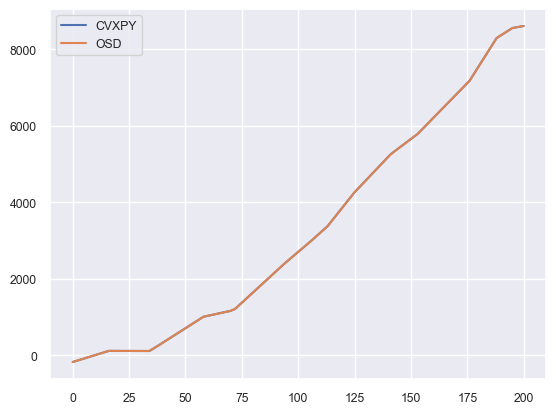

In [105]:
s_hat_cvxpy_mosek = cvx_sd(y, weight=3000)
s_hat_osd_mosek = osd_sd(y, weight=3000, solver="QSS")

obj_osd_scaled = cvx_sd(y, weight=3000, comp_osd=s_hat_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(s_hat_cvxpy_mosek, s_hat_osd_mosek):.2e}')


f, ax1 = plt.subplots()
ax1.plot(s_hat_cvxpy_mosek, label="CVXPY")
ax1.plot(s_hat_osd_mosek, label="OSD")
ax1.legend()
plt.show()